2023-11-5

BBME 520

Assignment 8 Part B

Javid Jannat

In [1]:
import numpy as np
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.image import index_img
from sklearn.preprocessing import StandardScaler
import nibabel as nib
from matplotlib import pyplot as plt
import sklearn

brain_data = datasets.fetch_oasis_vbm(n_subjects=100)
crad = datasets.fetch_atlas_craddock_2012()
output_variable = StandardScaler().fit_transform(brain_data.ext_vars.age[:, None])[:,0] # gives subject age on standard units after z-scoring

data_n = output_variable.size
sets_n = 43

input_variables = [None]*sets_n

for i in range(sets_n):

    if not (i==0 or i==sets_n-1): # this saves time as we dont need to load all of the sets
        continue

    atlas_nii = index_img(crad['scorr_mean'], i); #this needs to be modified for some tasks
    masker = NiftiLabelsMasker(labels_img= atlas_nii, standardize=True);
    input_variables[i] = masker.fit_transform(brain_data.gray_matter_maps);
    print('%i regions found in this atlas' % (len(np.unique(atlas_nii.get_fdata().ravel())) - 1))

C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\struct.py:850: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\nilearn\datasets\atlas.py:269: FutureWarning: The default behavior of the function will be deprecated and replaced in release 0.13 to use the new parameters homogeneity and grp_mean.
  warnings.warn(
C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\joblib\memory.py:353: FutureWarning: The d

10 regions found in this atlas
788 regions found in this atlas


C:\Users\Javid\AppData\Roaming\Python\Python311\site-packages\joblib\memory.py:353: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  return self.func(*args, **kwargs)


In [2]:
import sklearn
from sklearn import calibration

p_trainer = sklearn.linear_model.Ridge(alpha=1.0 , max_iter= 10000)

percentage_data = np.arange(10,100,10)

ranges = np.arange(data_n/10,data_n,data_n/10).astype(np.short)

train_ranges = []
test = np.arange(ranges[-1],data_n)

for r in ranges:
    train_ranges.append(np.arange(0,r))

In [3]:
#task 6

accuracies = np.zeros(9)

out = output_variable
inp = input_variables[0]

for i,train in enumerate(train_ranges):
    
    model= p_trainer.fit(inp[train],out[train])
    accuracies[i] = model.score(inp[test],out[test])

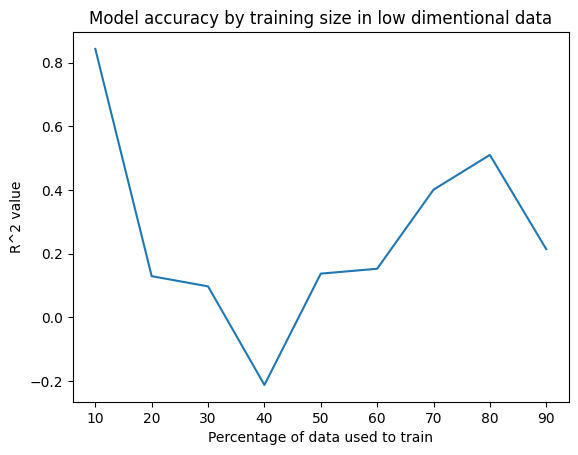

In [4]:
plt.title('Model accuracy by training size in low dimentional data');
plt.plot( accuracies.transpose());
plt.xticks(np.arange(9),percentage_data);
plt.xlabel('Percentage of data used to train');
plt.ylabel('R^2 value');

In [5]:
#task 7

accuracies = np.zeros(9)

out = output_variable
inp = input_variables[-1]

for i,train in enumerate(train_ranges):
    
    model= p_trainer.fit(inp[train],out[train])
    accuracies[i] = model.score(inp[test],out[test])

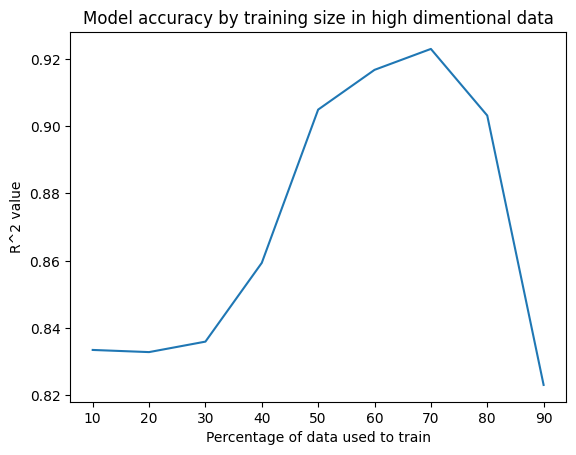

In [6]:
plt.title('Model accuracy by training size in high dimentional data');
plt.plot( accuracies.transpose());
plt.xticks(np.arange(9),percentage_data);
plt.xlabel('Percentage of data used to train');
plt.ylabel('R^2 value');

In [7]:
#task 8

r2 = np.zeros(9)
mae = np.zeros(9)
evs = np.zeros(9)
mse = np.zeros(9)

out = output_variable
inp = input_variables[0]

for i,train in enumerate(train_ranges):
    
    model= p_trainer.fit(inp[train],out[train])

    p = model.predict(inp[test])
    t = out[test]

    r2[i] = sklearn.metrics.r2_score(t,p)
    mae[i] = sklearn.metrics.mean_absolute_error(t,p)
    evs[i] = sklearn.metrics.explained_variance_score(t,p)
    mse[i] = sklearn.metrics.mean_squared_error(t,p)

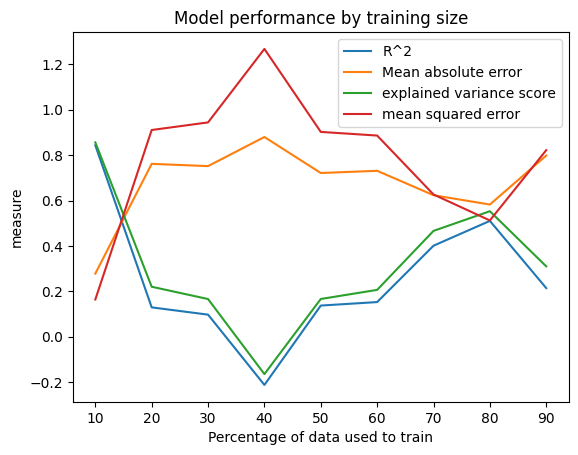

In [14]:
plt.title('Model performance by training size');
plt.plot(r2);
plt.plot(mae);
plt.plot(evs);
plt.plot(mse);

plt.legend(['R^2','Mean absolute error','explained variance score','mean squared error'])


plt.xticks(np.arange(9),percentage_data);
plt.xlabel('Percentage of data used to train');
plt.ylabel('measure');

In [9]:

bin_output = np.copy(output_variable)
sorted_indices = np.argsort(bin_output)
lows = sorted_indices[np.arange(0,50)]
highs = sorted_indices[np.arange(50,100)]

bin_output[lows] = 0
bin_output[highs] = 1

p_trainer = sklearn.linear_model.LogisticRegression(penalty='l2',C=1.0 , max_iter= 10000)

In [10]:
#task 9


predictions = np.zeros(100)
splits_n = 10
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)

out = bin_output
inp = input_variables[0]

index_generator = splitter.split(inp,out)

for train,test in index_generator:
    
    model= p_trainer.fit(inp[train],out[train])
    predictions[test] = model.predict(inp[test])

c_mat = sklearn.metrics.confusion_matrix(out,predictions)

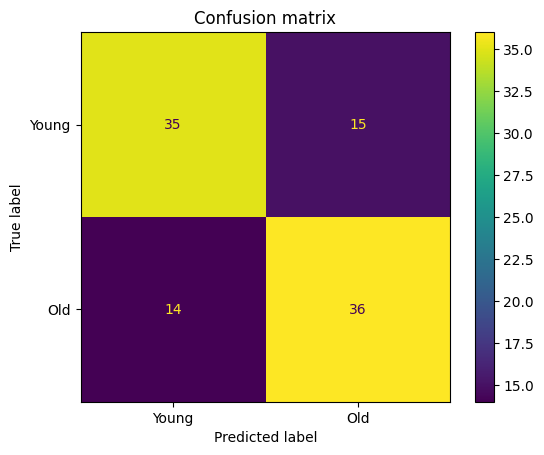

In [11]:
sklearn.metrics.ConfusionMatrixDisplay(c_mat).plot();
plt.title('Confusion matrix');
plt.xticks([0,1],['Young','Old']);
plt.yticks([0,1],['Young','Old']);

In [12]:
#task 10

predictions = np.zeros(100)
splits_n = 10
splitter = sklearn.model_selection.KFold(n_splits=splits_n, shuffle=False)

out = bin_output
inp = input_variables[0]

index_generator = splitter.split(inp,out)

for train,test in index_generator:
    
    model= p_trainer.fit(inp[train],out[train])
    predictions[test] = model.predict_proba(inp[test])[:,1]

c_curve = sklearn.calibration.calibration_curve(out,predictions)

Text(0, 0.5, 'observed proportion')

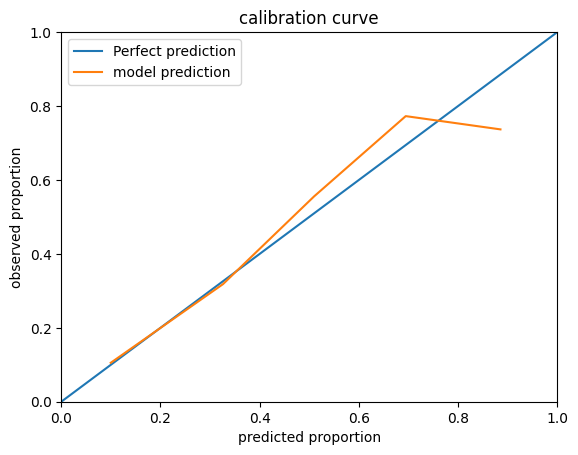

In [13]:
x = np.arange(0,1.25,0.25)
plt.plot(x,x)
plt.plot(c_curve[1],c_curve[0])
plt.title("calibration curve")
plt.ylim([0,1])
plt.xlim([0,1])
plt.legend(['Perfect prediction','model prediction'])
plt.xlabel('predicted proportion')
plt.ylabel('observed proportion')